len(freqs): 20 and freqs: [ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45 -0.5  -0.45
 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05]
len(spectrum): 20 and spectrum: [ 0. +0.j 10. +0.j  0. +0.j  5. +0.j  0. +0.j  3.5+0.j  0. +0.j  0. +0.j
  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  3.5+0.j
  0. +0.j  5. +0.j  0. +0.j 10. +0.j]
len(template): 20 and template: [ 1.85000000e+00+0.j  1.24494914e+00+0.j  3.04508497e-01+0.j
  1.12256994e-01+0.j  2.54508497e-01+0.j -8.88178420e-17+0.j
 -2.54508497e-01+0.j -1.12256994e-01+0.j -3.04508497e-01+0.j
 -1.24494914e+00+0.j -1.85000000e+00+0.j -1.24494914e+00+0.j
 -3.04508497e-01+0.j -1.12256994e-01+0.j -2.54508497e-01+0.j
 -8.88178420e-17+0.j  2.54508497e-01+0.j  1.12256994e-01+0.j
  3.04508497e-01+0.j  1.24494914e+00+0.j]


/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


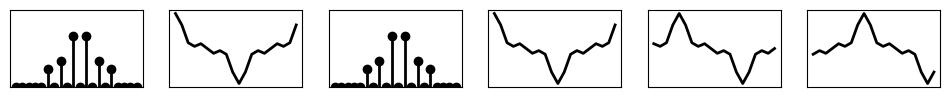

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Generate template array from Fourier spectrum
n = 20  # Size of array
freqs = np.fft.fftfreq(n)
print(f"len(freqs): {len(freqs)} and freqs: {freqs}")
spectrum = np.zeros(n, dtype=complex)

# Set only three frequencies with specific amplitudes
spectrum[1] = 10 # Positive frequency
spectrum[-1] = 10  # Negative frequency (conjugate)
spectrum[3] = 5 # Second frequency
spectrum[-3] =  5  # Its conjugate
spectrum[5] = 3.5  # Third frequency 
spectrum[-5] = 3.5  # Its conjugate
print(f"len(spectrum): {len(spectrum)} and spectrum: {spectrum}")

# Generate signal from spectrum
template = np.fft.ifft(spectrum) #.real
print(f"len(template): {len(template)} and template: {template}")
t = np.linspace(0, 2*np.pi, n)

# Generate dataset by rolling
arrays = []
shifts = []
for k in range(n):
    arrays.append(np.roll(template, k))
    shifts.append(k)
arrays = np.array(arrays)
shifts = np.array(shifts)

# Plot original spectrum, signal and its spectrum (sanity check)
plt.figure(figsize=(12, 1))
plt.subplot(1, 6, 1)
max_spectrum = np.max(np.abs(spectrum))
plt.vlines(freqs, 0, np.abs(spectrum), linewidth=2, color='black')
plt.plot(freqs, np.abs(spectrum), 'o', markerfacecolor='black', markersize=6, color='black')
plt.ylim(0, max_spectrum * 1.5)  # Add 10% padding at top
plt.xticks([])
plt.yticks([])

plt.subplot(1, 6, 2)
plt.plot(t, template, color='black', linewidth=2)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 6, 3)
check_spectrum = np.abs(np.fft.fft(template))
max_check = np.max(check_spectrum)
plt.vlines(freqs, 0, check_spectrum, linewidth=2, color='black')
plt.plot(freqs, check_spectrum, 'o', markerfacecolor='black', markersize=6, color='black')
plt.ylim(0, max_check * 1.5)  # Add 10% padding at top
plt.xticks([])
plt.yticks([])

# Plot some rolled versions
for i in range(3):
    plt.subplot(1, 6, i+4)
    plt.plot(t, arrays[i*4], color='black', linewidth=2)
    plt.xticks([])
    plt.yticks([])
#plt.tight_layout()
plt.savefig('template.svg', format='svg')
plt.show()


In [2]:
torch.combinations(torch.tensor([2., 3., 4.]), 2)

tensor([[2., 3.],
        [2., 4.],
        [3., 4.]])

In [3]:
# Create neural network
class AdditionArrays(nn.Module):
    def __init__(self, n, mi=1, mj=1, alpha=1e-5):
        super().__init__()
        self.fc1_u_v = nn.Linear(2*n, n)
        self.fc2_w = nn.Linear(n, n)
        self.mi = mi
        self.mj = mj
        self.alpha = alpha
        
    def forward(self, x):
        x = self.fc1_u_v(x)
        x = x ** (self.mi + self.mj) # Nonlinearity depends on mi and mj
        x = self.fc2_w(x)
        return  self.alpha * x

# Create custom dataset
class ArrayShiftDataset(Dataset):
    def __init__(self, arrays, shifts, mi=1, mj=1):
        self.arrays = torch.FloatTensor(arrays)
        self.shifts = torch.LongTensor(shifts)
        self.x = torch.zeros((len(self.arrays) * len(self.arrays), 2 * n))
        self.y = torch.zeros((len(self.arrays) * len(self.arrays), n))
        for i in range(len(self.arrays)):
            for j in range(len(self.arrays)):
                self.x[i * len(self.arrays) + j] = torch.cat([self.arrays[i], self.arrays[j]])
                self.y[i * len(self.arrays) + j] = self.arrays[(i * mi + j * mj) % len(self.arrays)]
        
    def __len__(self):
        # all possible combinations of two arrays
        return len(self.arrays) * len(self.arrays)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Create dataset and dataloader
mi = 2
mj = 3
dataset = ArrayShiftDataset(arrays, shifts, mi=mi, mj=mj)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


/tmp/ipykernel_275055/606500794.py:20: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /pytorch/aten/src/ATen/native/Copy.cpp:308.)
  self.arrays = torch.FloatTensor(arrays)


Epoch 1/100001, Loss: 0.686250


/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


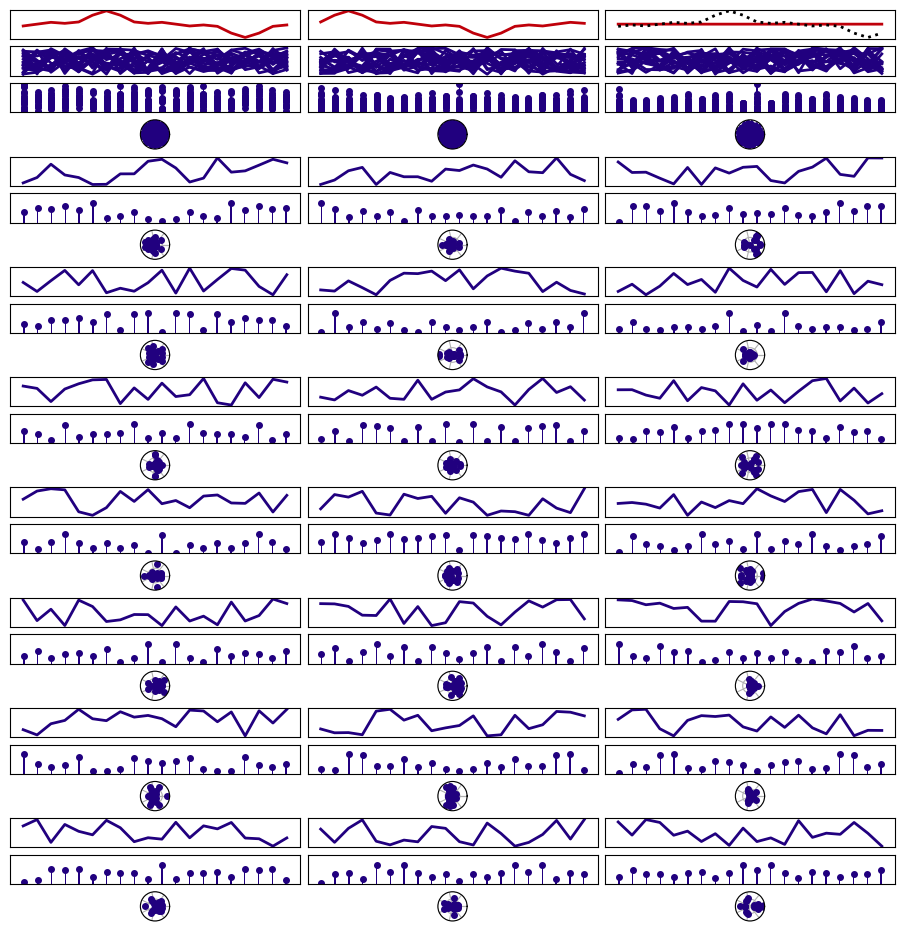

Epoch 11/100001, Loss: 0.686169


/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


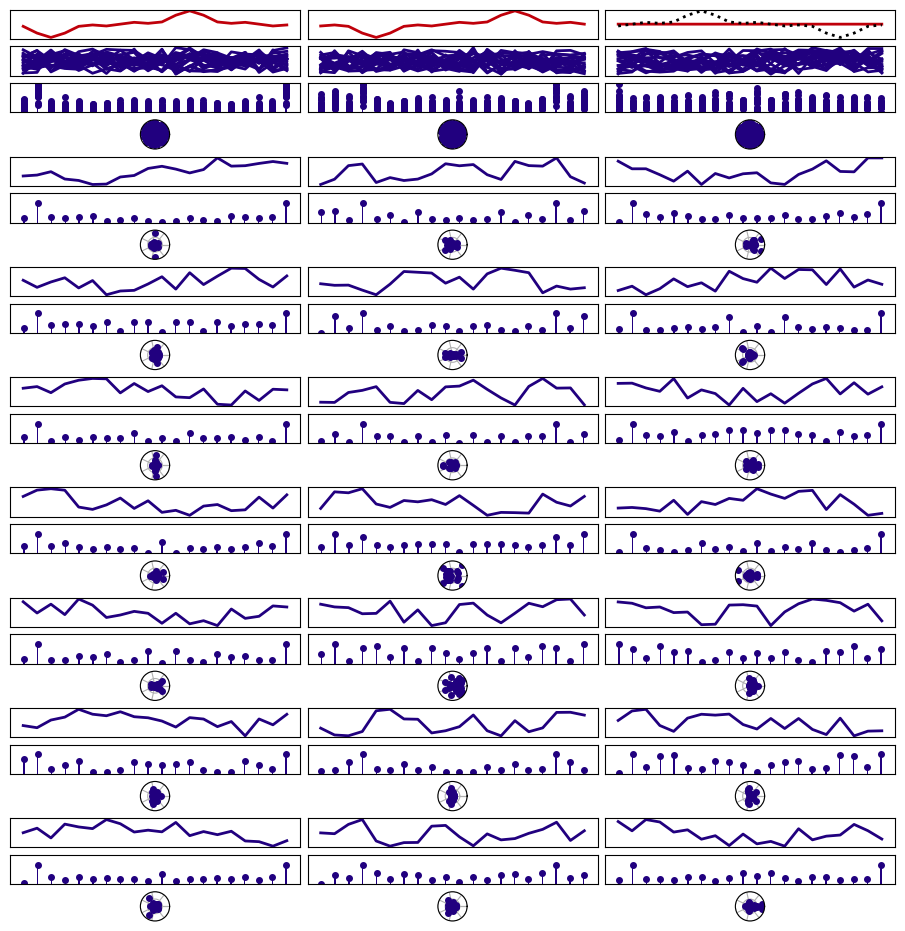

Epoch 31/100001, Loss: 0.520036


/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


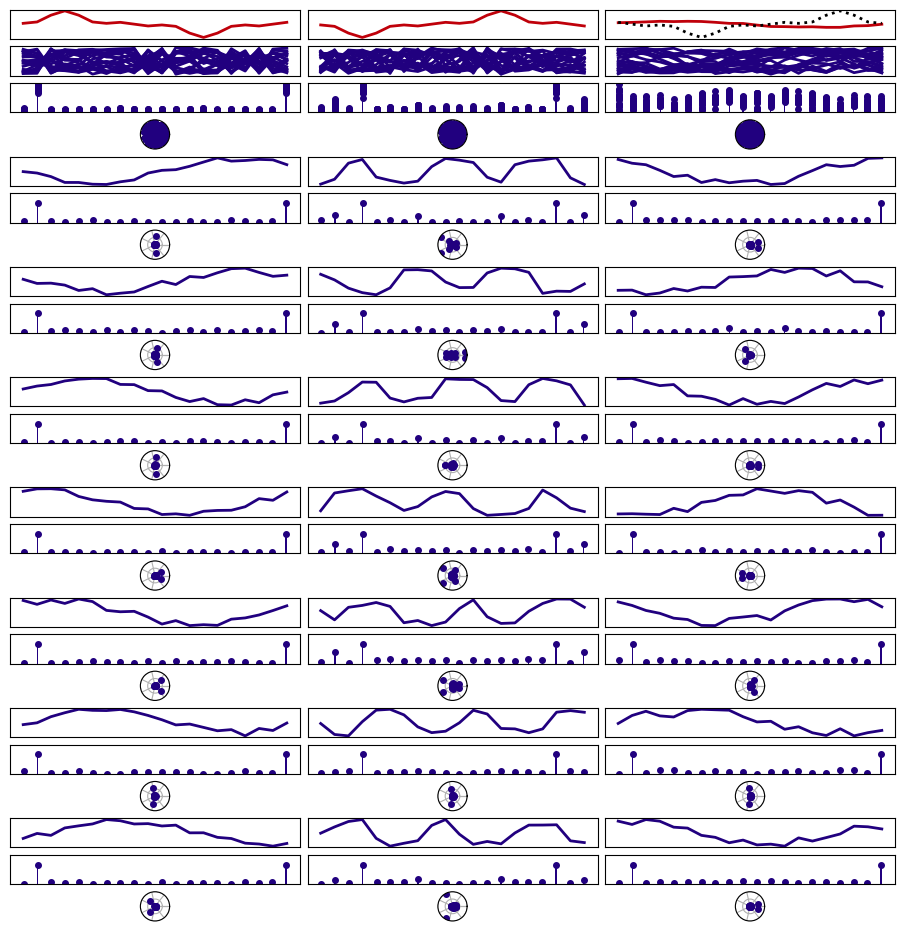

Epoch 101/100001, Loss: 0.190734


/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


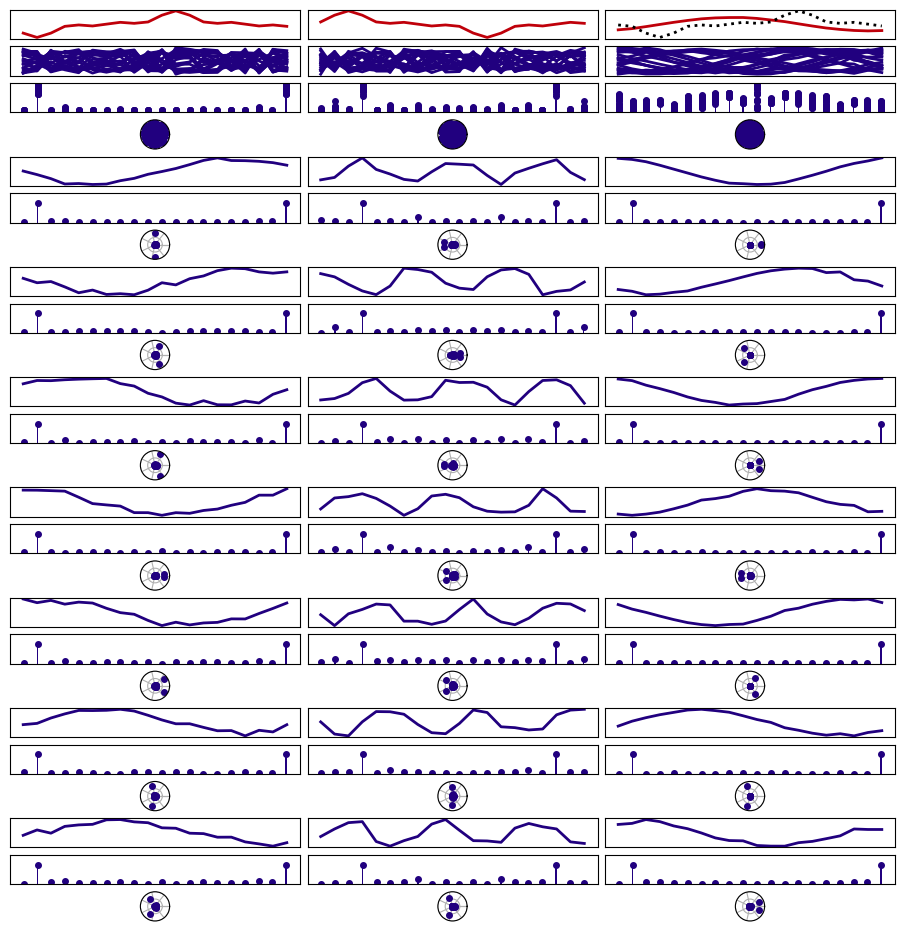

Epoch 501/100001, Loss: 0.185726


/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


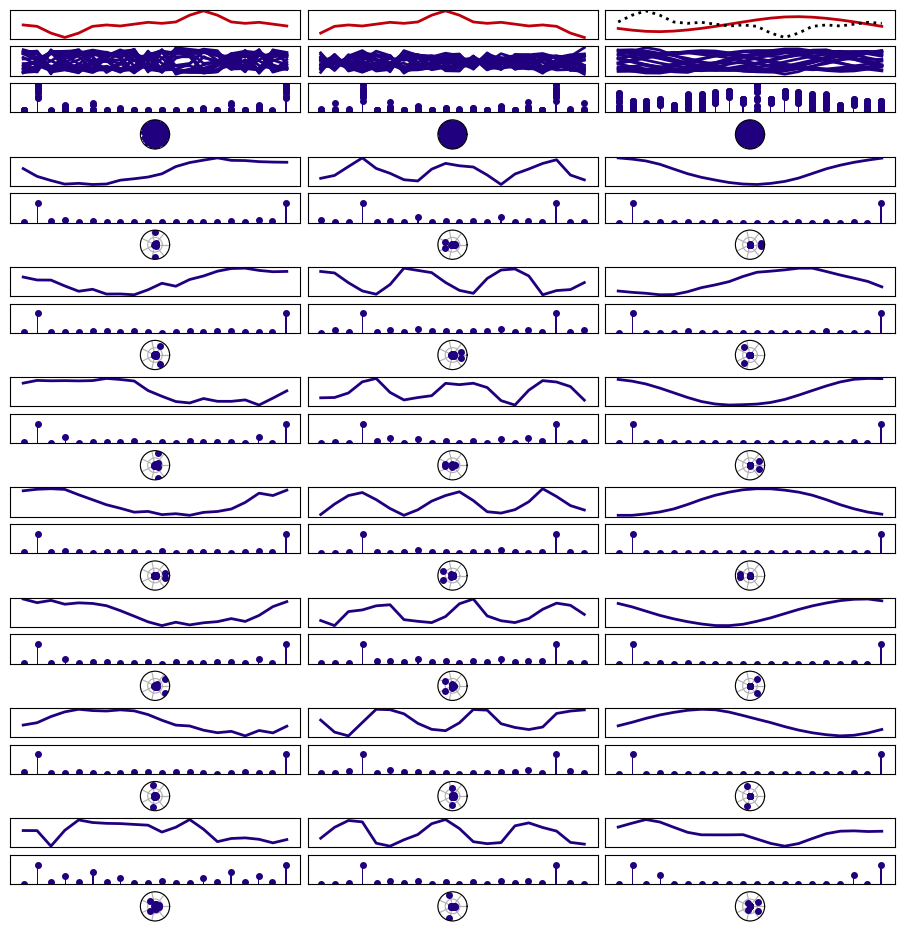

Epoch 1001/100001, Loss: 0.180578


/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


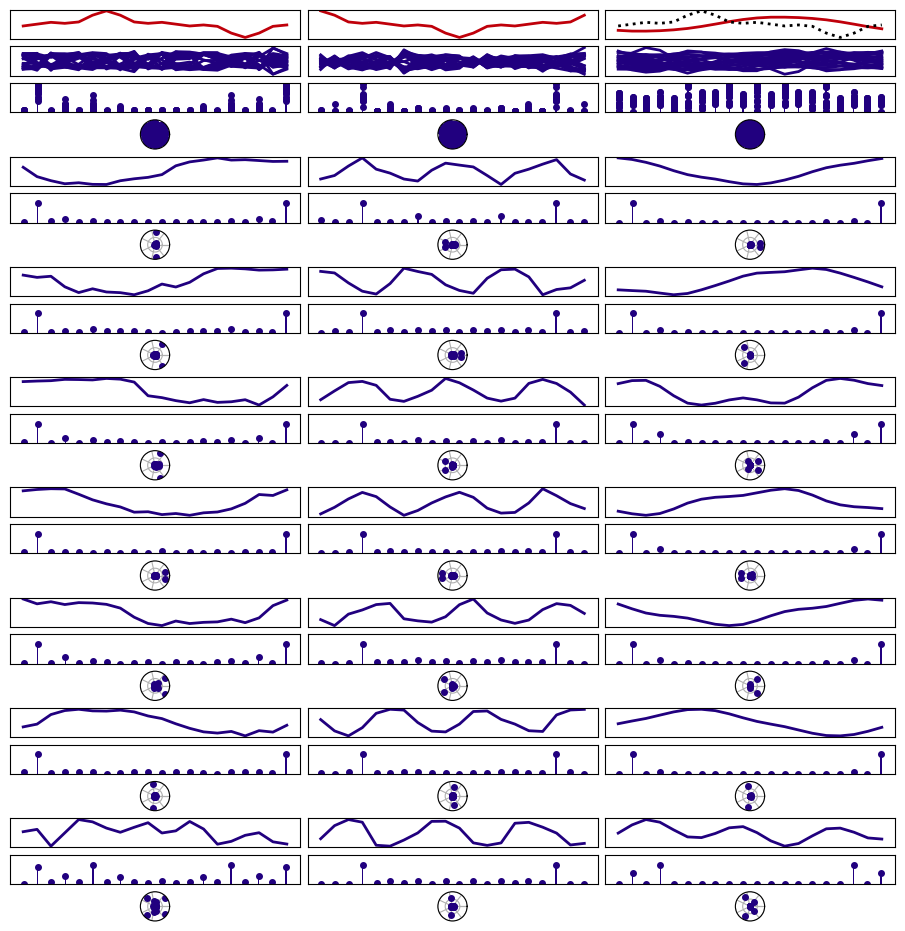

Epoch 2001/100001, Loss: 0.163524


/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


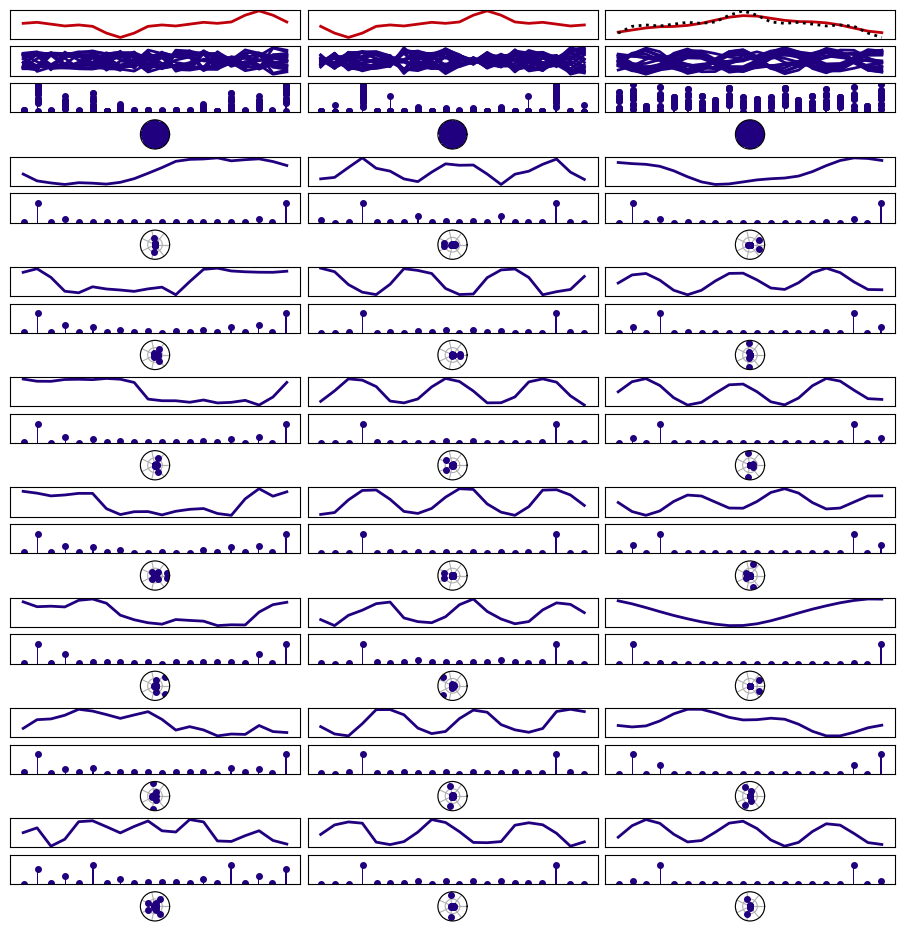

Epoch 3001/100001, Loss: 0.118071


/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


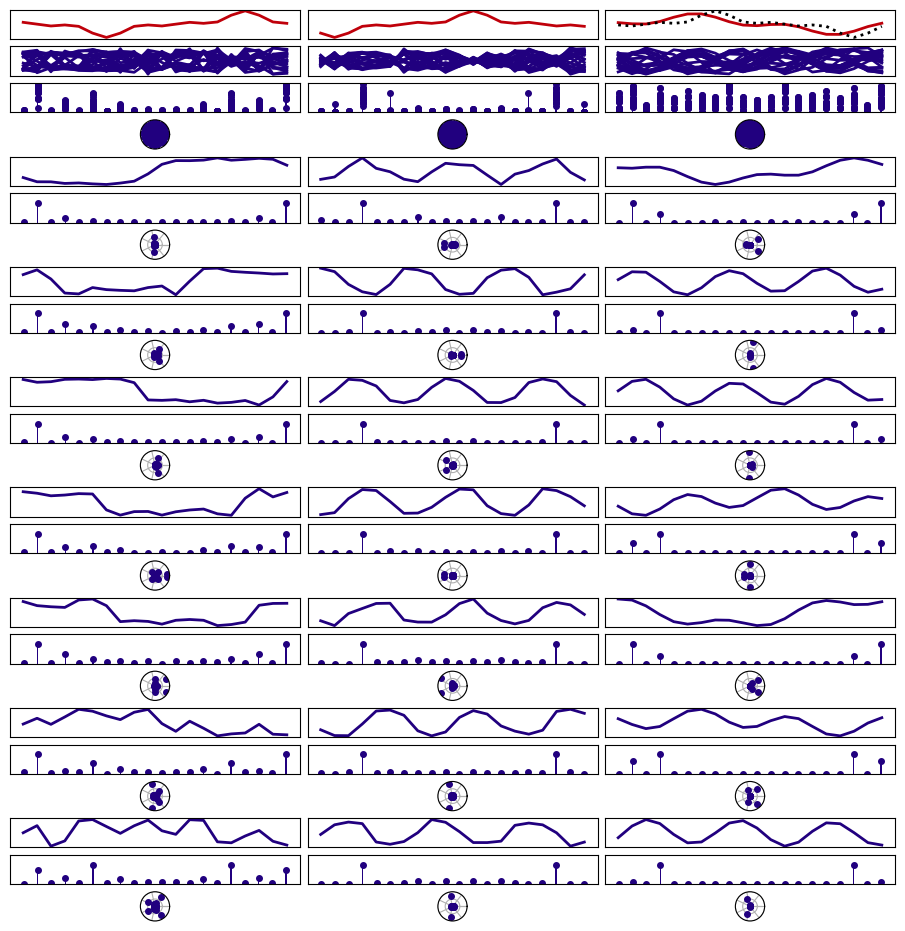

Epoch 5001/100001, Loss: 0.113366


/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


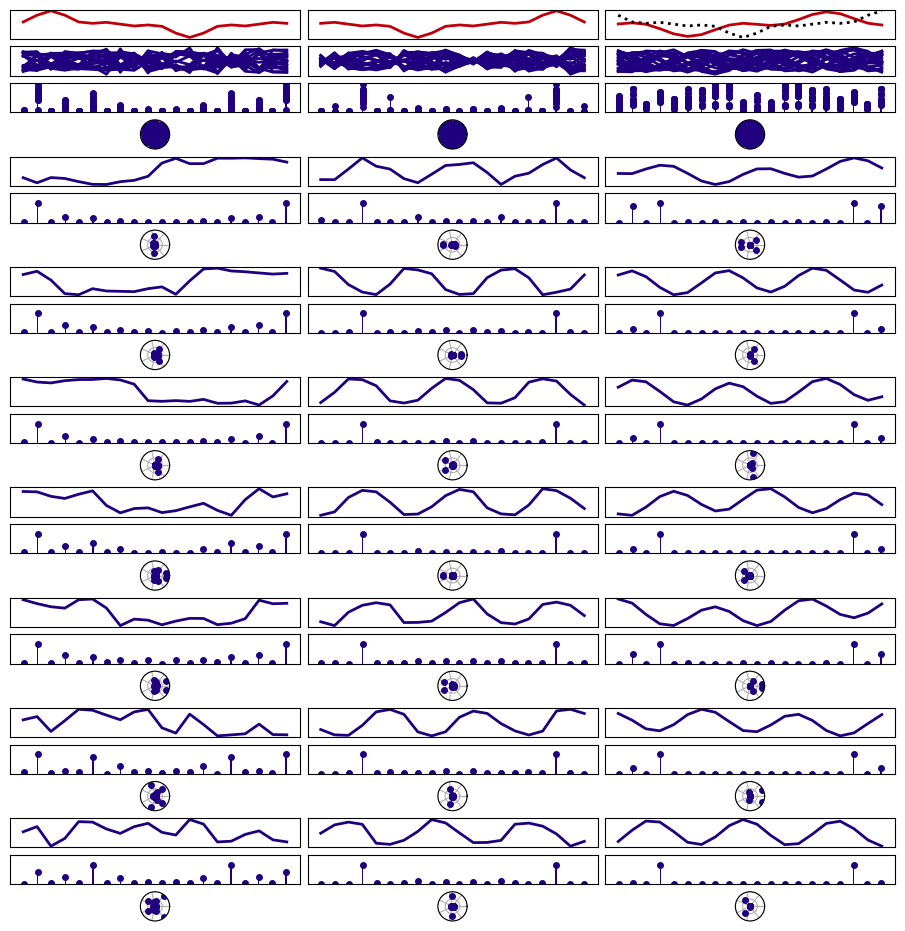

Epoch 10001/100001, Loss: 0.080871


/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


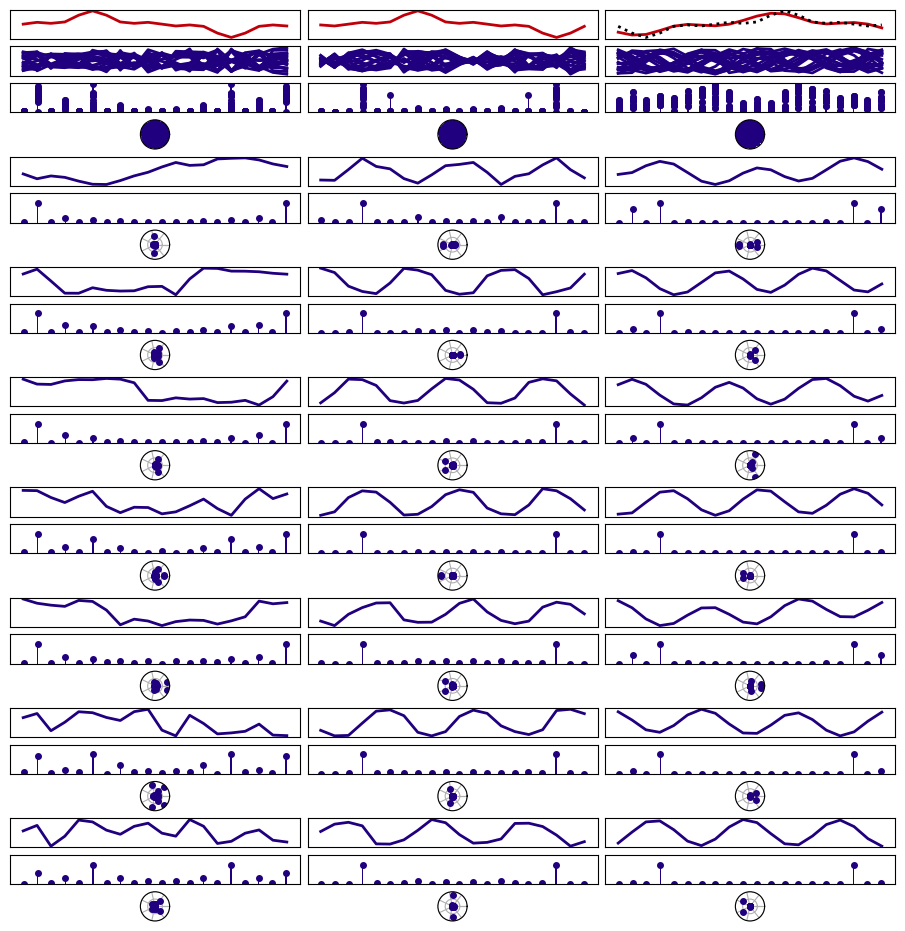

Epoch 15001/100001, Loss: 0.105765


/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


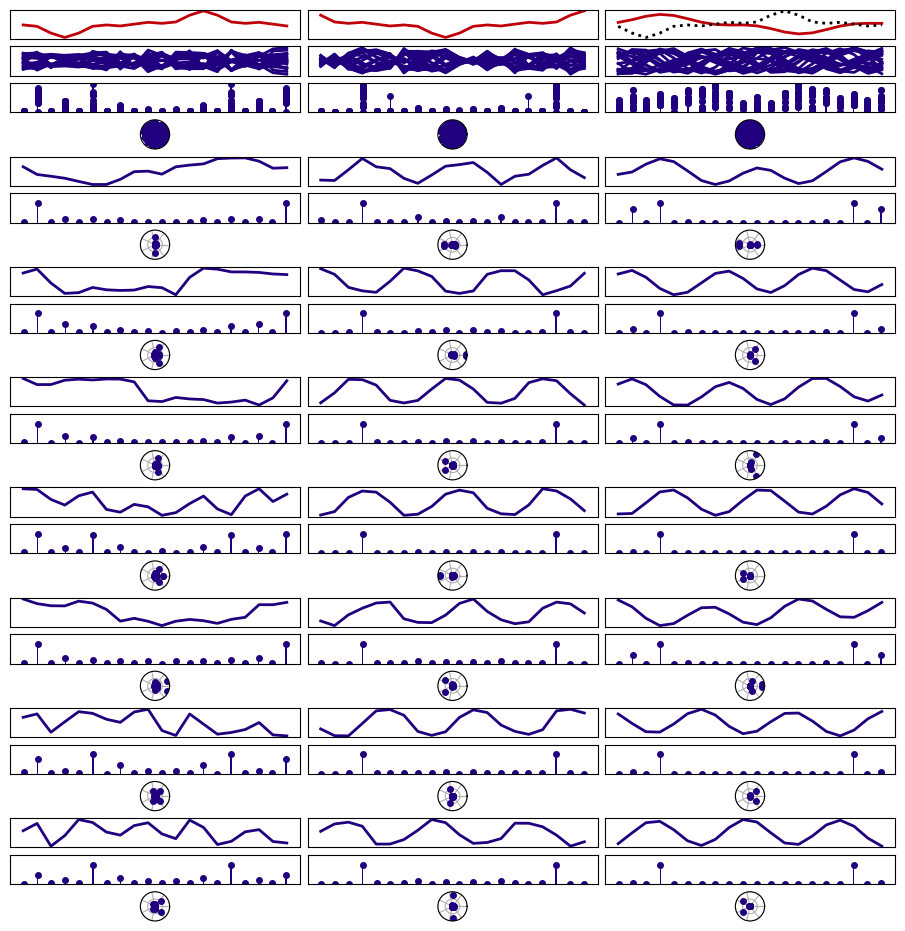

Epoch 20001/100001, Loss: 0.081869


/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


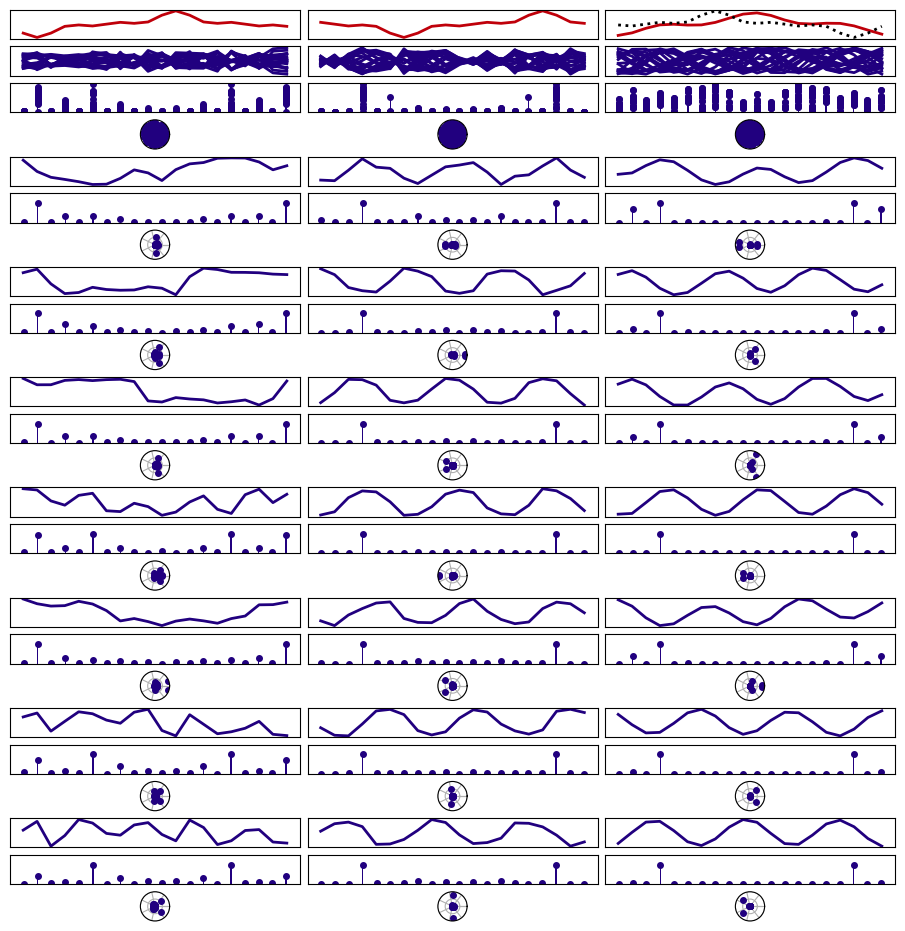

Epoch 50001/100001, Loss: 0.069211


/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nmiolane/anaconda3/envs/bispectra/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


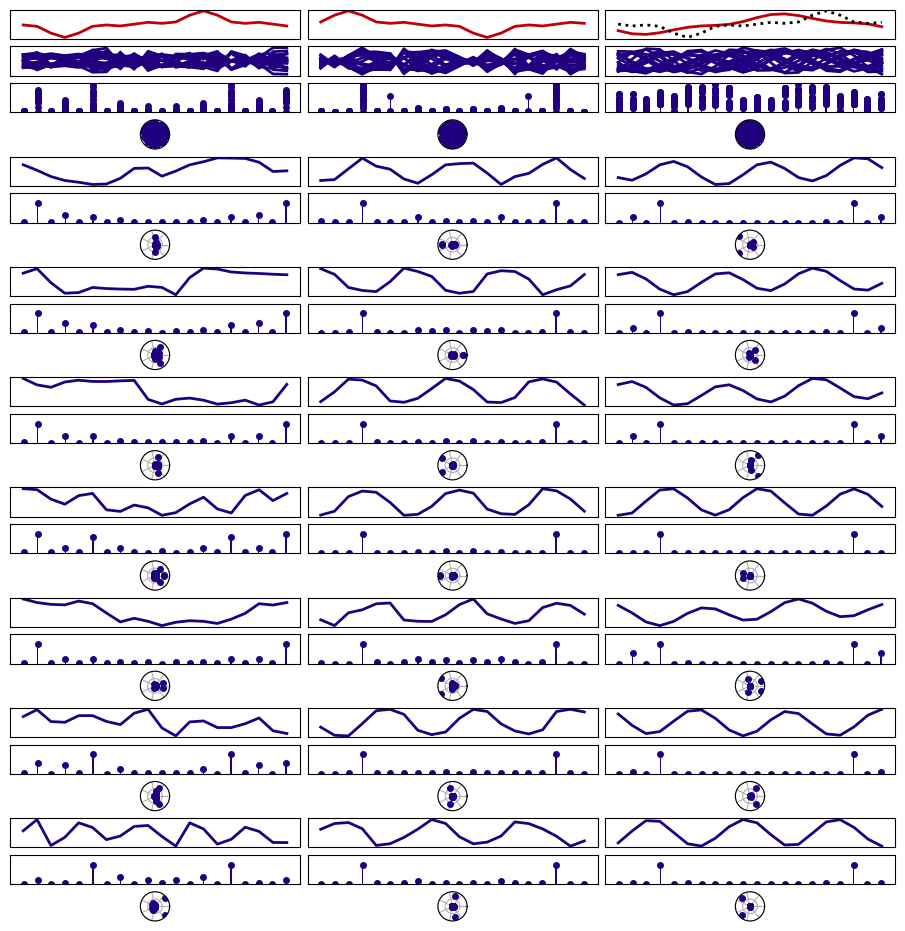

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AdditionArrays(n, mi=mi, mj=mj).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop
n_epochs = 100001
losses = []
epoch_to_plot = [0, 10, 30, 100, 500, 1000, 2000, 3000, 5000, 10000, 15000,  20000, 50000, 100000] #, 9999]
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)  # Add this line to store the average loss
    # Plot results
    if epoch in epoch_to_plot:
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.6f}')
        model.eval()
        with torch.no_grad():
            # Get two random examples
            idx1, idx2 = np.random.randint(0, len(arrays), 2)
            x = torch.cat([torch.FloatTensor(arrays[idx1]), 
                          torch.FloatTensor(arrays[idx2])]).to(device)
            output = model(x).cpu().numpy()
            target = arrays[(shifts[idx1] + shifts[idx2]) % n]
            
            plt.rcParams.update({'font.size': 5})
            fig = plt.figure(figsize=(9, 10))
            
            # Get the model weights
            weights = []
            for name, param in model.named_parameters():
                if 'weight' in name:
                    weights.append(param.detach().cpu().numpy())

            # Row 1: Input/Output plots
            for i, data in enumerate([arrays[idx1], arrays[idx2], output]):
                plt.subplot(27, 3, i+1)
                plt.plot(data, linewidth=2, color='#bf000a')
                if i == 2:  # Add target line for output plot
                    plt.plot(target, ':', linewidth=2, color='black')
                plt.xticks([])
                plt.yticks([])
            


            # Define weight combinations for plotting
            weight_data = [
                (weights[0][:,:n], '#21007f'),
                (weights[0][:,n:], '#21007f'),
                (weights[1], '#21007f')
            ]

            base_idx = 3  # Starting subplot index for this weight

            for i, (w, color) in enumerate(weight_data):
                plt.subplot(27, 3, base_idx +1+i)
                plt.plot(w, linewidth=2,color=color)
                plt.xticks([])
                plt.yticks([])
            for i, (w, color) in enumerate(weight_data):
                # plot the spectrum of the weight
                spectrum = np.abs(np.fft.fft(w))
                plt.subplot(27, 3, base_idx +1+i+3)
                for spec in spectrum:
                    plt.bar(range(len(spec)), spec, width=0.1, color=color)
                    plt.plot(range(len(spec)), spec, 'o', color=color, markersize=4)
                plt.xticks([])
                plt.yticks([])
            for i, (w, color) in enumerate(weight_data):
                # plot the phase of the weight
                phase = np.angle(np.fft.fft(w))
                plt.subplot(27, 3, base_idx +1+i+6, projection='polar')
                plt.plot(phase, linewidth=2,color=color)
                plt.xticks([])
                plt.yticks([])
                

            # Plot remaining rows
            for row in range(7):  # For each weight example (first, second, third)
                base_idx = row * 9 + 13  # Starting subplot index for this weight
                
                # Line plots of weights
                for i, (w, color) in enumerate(weight_data):
                    plt.subplot(27, 3, base_idx + i)
                    plt.plot(w[row] if i < 2 else w[:,row], linewidth=2, color=color)
                    plt.xticks([])
                    plt.yticks([])

                # Power spectra
                for i, (w, color) in enumerate(weight_data):
                    plt.subplot(27, 3, base_idx + i + 3)
                    data = w[row] if i < 2 else w[:,row]
                    spectrum = np.abs(np.fft.fft(data))
                    plt.bar(range(len(spectrum)), spectrum, width=0.1, color=color)
                    plt.plot(range(len(spectrum)), spectrum, 'o', color=color, markersize=4)
                    plt.ylim(0, max(spectrum) * 1.5)
                    plt.xticks([])
                    plt.yticks([])

                # Phase plots
                for i, (w, color) in enumerate(weight_data):
                    plt.subplot(27, 3, base_idx + i + 6, projection='polar')
                    data = w[row] if i < 2 else w[:,row]
                    phases = np.angle(np.fft.fft(data))
                    magnitudes = np.abs(np.fft.fft(data))
                    plt.plot(phases, magnitudes, 'o', color=color, markersize=4)
                    plt.grid(True)
                    plt.xticks(np.linspace(0, 2*np.pi, 8), [''] * 8)
                    plt.yticks(plt.yticks()[0], [''] * len(plt.yticks()[0]))

            plt.tight_layout()
            plt.savefig(f'training_plots_epoch_{epoch}.svg', format='svg')
            plt.show()

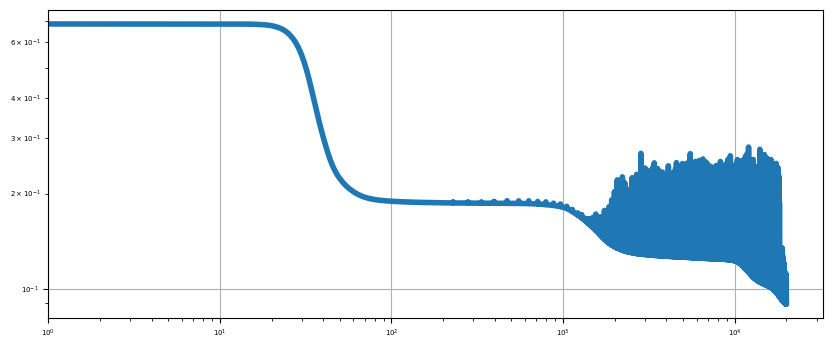

In [6]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(np.arange(1, len(losses)+1), losses, linewidth=4)  # Start epochs at 1
plt.xscale('log')  # Using log scale for epochs
plt.yscale('log')  # Using log scale since loss typically decreases exponentially
plt.xlim(left=1)  # Set x-axis minimum to 10^0
plt.grid(True)
plt.savefig('training_loss.svg', format='svg')
plt.show()